### Main Page: 

[kaggle](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

### Purpose

We are asking you to predict total sales for every product and store in the next month. 

### Q&A

[number of products only](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/57778)

### Download Data

``` sh
kaggle competitions download -c competitive-data-science-predict-future-sales
```

### Data Field Description

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### File Description
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv - supplemental information about the items categories.
- shops.csv - supplemental information about the shops.

### Evaluation 

Evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

### My Minutes
- item price in testdata could found in train

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy.stats import norm, skew
import seaborn as sns
import matplotlib as mpl

In [42]:
%matplotlib inline
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# output each line result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True)

In [7]:
train_file_path = '../../data/predict_future_sales/sales_train.csv'
test_file_path = '../../data/predict_future_sales/test.csv'

In [8]:
items_file_path = '../../data/predict_future_sales/items.csv'
item_categories_file_path = '../../data/predict_future_sales/item_categories.csv'
shops_file_path = '../../data/predict_future_sales/shops.csv'

In [526]:
dr = pd.read_csv(train_file_path)
dr.head()
test = pd.read_csv(test_file_path)
test.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [527]:
shop = pd.read_csv(shops_file_path)
shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [528]:
item_category = pd.read_csv(item_categories_file_path)
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [529]:
item = pd.read_csv(items_file_path)
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [531]:
# pre process for train and test
def join_category(dr):
    # dr get item_category_id by item_id
    return dr.join(item[['item_id', 'item_category_id']].set_index('item_id'), on='item_id')
train = join_category(dr)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [532]:
# add month
def get_month(x):
    [d, m, y] = x.split('.')
    return m + '.' + y
train['month'] = train['date'].apply(lambda x: get_month(x))
# train['month'] = pd.to_datetime(train['month'], format='%m.%Y', errors='coerce')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month
0,02.01.2013,0,59,22154,999.00,1.0,37,01.2013
1,03.01.2013,0,25,2552,899.00,1.0,58,01.2013
2,05.01.2013,0,25,2552,899.00,-1.0,58,01.2013
3,06.01.2013,0,25,2554,1709.05,1.0,58,01.2013
4,15.01.2013,0,25,2555,1099.00,1.0,56,01.2013


In [549]:
train.query('date_block_num==33')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month
2882335,23.10.2015,33,45,13315,649.0,1.0,47,10.2015
2882336,05.10.2015,33,45,13880,229.0,1.0,55,10.2015
2882337,02.10.2015,33,45,13881,659.0,1.0,55,10.2015
2882338,12.10.2015,33,45,13881,659.0,1.0,55,10.2015
2882339,04.10.2015,33,45,13923,169.0,1.0,40,10.2015
2882340,31.10.2015,33,45,14227,99.0,1.0,30,10.2015
2882341,12.10.2015,33,45,14931,799.0,1.0,69,10.2015
2882342,05.10.2015,33,45,14101,449.0,1.0,55,10.2015
2882343,20.10.2015,33,45,14957,299.0,1.0,47,10.2015
2882344,05.10.2015,33,45,14102,749.0,1.0,55,10.2015


In [536]:
# add item_cnt_month
item_cnt_month = train.groupby(['shop_id', 'item_id', 'month'])['item_cnt_day'].sum().to_frame(name=
                                                                                               'item_cnt_month'
                                                                                              )
item_cnt_month = item_cnt_month.reset_index()
tmp = train.merge(item_cnt_month, how="left", on = ["shop_id", "item_id", "month"])
train_month = tmp
len(train_month)
train_month.head()

2935849

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,37,01.2013,1.0
1,03.01.2013,0,25,2552,899.00,1.0,58,01.2013,0.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,01.2013,0.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,01.2013,1.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,01.2013,1.0


In [537]:
# pivot to p_series
p_series = train_month.pivot_table(index=['shop_id','item_id'], columns='month', values='item_cnt_month').fillna(0.0)
p_series = p_series.reset_index()
len(p_series)
p_series.head()

424124

month,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,...,09.2013,09.2014,09.2015,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014
0,0,30,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [544]:
train_month.head()
ip_avg = train_month.groupby(['shop_id', 'item_id'])['item_price'].mean().to_frame(name='item_price').reset_index()

tmp = None

# add item price, cat_id
tmp = p_series.merge(ip_avg, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'], how='left') \
              .merge(item[['item_id', 'item_category_id']], left_on=['item_id'], right_on=['item_id'], how="left")


# pd.isnull(tmp['item_price']).sum()
len(tmp)
p_series = tmp
p_series.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,37,01.2013,1.0
1,03.01.2013,0,25,2552,899.00,1.0,58,01.2013,0.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,01.2013,0.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,01.2013,1.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,01.2013,1.0


424124

,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,...,09.2015,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014,item_price,item_category_id
0,0,30,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,40
1,0,31,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,37
2,0,32,6.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.0,40
3,0,33,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0,37
4,0,35,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,40


In [551]:
# concat train and test for analysizing distribution
print("train len:")
len(p_series)

print("test len:")
len(test_with_cat)

tmp = None
tmp = p_series.merge(test, how='outer', on = ["shop_id", "item_id"])

print("train + test len:")
len(tmp)

print("id is null")
len(tmp[pd.isnull(tmp['ID'])])

print("id is not null")
len(tmp[pd.notnull(tmp['ID'])])

train len:


424124

test len:


214200

train + test len:


526920

id is null


312720

id is not null


214200

### xgboost
### =================================

In [550]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

In [554]:
test_with_cat.head()
p_series.head()

,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,1,5,5320,55
2,2,5,5233,19
3,3,5,5232,23
4,4,5,5268,20


,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,...,09.2015,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014,item_price,item_category_id
0,0,30,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,40
1,0,31,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,37
2,0,32,6.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.0,40
3,0,33,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0,37
4,0,35,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,40


In [556]:
id_ = ['shop_id', 'item_id']
y_column = ['10.2015']
x_column = list(set(p_series.columns) - set(id_) - set(y_column))

In [562]:
xgbr = xgb.XGBRegressor(**param).fit(p_series[x_column], p_series[y_column])

In [566]:
p_series['y_xgb_predict'] = xgbr.predict(p_series[x_column])
p_series.head()

,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,...,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014,item_price,item_category_id,y_xgb_predict
0,0,30,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,40,0.039235
1,0,31,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,37,0.065615
2,0,32,6.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.0,40,-0.000514
3,0,33,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0,37,0.009230
4,0,35,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,40,-0.000514


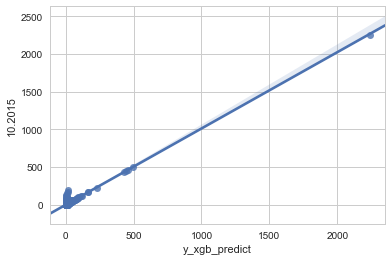

In [568]:
sns.regplot(x="y_xgb_predict", y=y_column[0], data=p_series, color='b')

In [573]:
len(test_with_cat)
test_with_x_feature = test_with_cat.merge(p_series, left_on=id_, right_on=id_, how="left").fillna(0.0)
test_with_x_feature['item_category_id'] = test_with_x_feature['item_category_id_x']
test_with_x_feature.head()

214200

,ID,shop_id,item_id,item_category_id_x,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,...,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014,item_price,item_category_id_y,y_xgb_predict,item_category_id
0,0,5,5037,19,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,1633.692308,19.0,0.459508,19
1,1,5,5320,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,55
2,2,5,5233,19,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,865.666667,19.0,0.907241,19
3,3,5,5232,23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,599.000000,23.0,0.166457,23
4,4,5,5268,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,20


In [575]:
test_with_x_feature["y_xgb_predict"] = xgbr.predict(test_with_x_feature[x_column])

In [595]:
# compute error
np.sqrt(mean_squared_error(test_with_x_feature[y_column],
                           test_with_x_feature["y_xgb_predict"]))

preds = test_with_x_feature["y_xgb_predict"].values
preds
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
preds

1.0568969780680157

array([ 0.45950845,  0.0509274 ,  0.90724134, ...,  0.01143768,
        0.04130161,  0.07982135], dtype=float32)

[0.45950845,
 0.050927401,
 0.90724134,
 0.16645744,
 0.54844427,
 0.19045681,
 2.1678076,
 0.1184622,
 1.6732737,
 0.54844427,
 2.551127,
 0.40362522,
 0,
 0.48589244,
 1.3847632,
 2.0141513,
 0.063104659,
 0.13371399,
 1.49104,
 0.24750999,
 0.72346461,
 0,
 0.87525606,
 0.74575704,
 1.2166245,
 0.54844427,
 0.0022803247,
 0.50051486,
 0.79264534,
 6.2357416,
 0.9042955,
 0.12527126,
 0.67911917,
 0.90227115,
 0.081513882,
 0.10102394,
 0.077252537,
 0.88726246,
 0.30351311,
 0.23116043,
 0.64570022,
 2.0577893,
 3.8945644,
 4.3333406,
 0.59689635,
 0.040500641,
 1.0562809,
 0.17204148,
 0.43116379,
 0.66196454,
 2.401227,
 0.28357416,
 0.078085095,
 0.20083344,
 7.042973,
 2.464653,
 1.168852,
 1.7062453,
 4.9841514,
 4.2939663,
 5.7555013,
 0.2181164,
 0.51934522,
 0.15709409,
 0.040801734,
 0.050927401,
 0.71386284,
 0.050827593,
 0.5566135,
 0,
 0.050927401,
 0.43656141,
 0.16330218,
 1.1762257,
 0.098812252,
 0.54844427,
 0.12037319,
 0.040801734,
 0.53541279,
 1.0078055,
 1.488

### ================================

### Output Result

In [597]:
# Output
sub = pd.DataFrame({'ID':test_with_x_feature.ID,'item_cnt_month': preds })
sub.head(10)

,ID,item_cnt_month
0,0,0.459508
1,1,0.050927
2,2,0.907241
3,3,0.166457
4,4,0.548444
5,5,0.190457
6,6,2.167808
7,7,0.118462
8,8,1.673274
9,9,0.548444


In [281]:
sub['ID'] = sub['ID'].apply(int)
sub.to_csv('/Users/albert_chen/workspace/result.csv',index=False)

84580     0
424124    0
87048     0
87008     0
424125    0
84680     0
84778     0
84932     0
88883     0
424126    0
80219     0
81281     0
77056     1
81459     0
81508     7
81609     0
424127    0
78312     0
82043     0
82928     0
79164     0
424128    0
98092     4
97688     0
99638     0
424129    0
424130    0
95213     4
95551     0
96302     0
         ..
526909    0
373340    0
344476    0
526910    0
132189    0
115773    0
526911    0
209600    0
172360    0
45955     0
385719    0
399724    0
95952     1
526912    0
526913    0
270395    0
526914    0
90195     0
526915    0
526916    0
50705     0
72898     0
71430     2
346409    0
526917    0
354409    0
526918    0
299172    0
526919    0
6656      0
Name: item_cnt_month, dtype: int64

In [282]:
with open('/Users/albert_chen/workspace/result.csv', 'r') as f:
    lines = f.readlines()
    print(lines[:3])

['ID,item_cnt_month\n', '0,0\n', '1,0\n']
